In [118]:
%matplotlib inline

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

Using TensorFlow backend.


In [119]:
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime
import bs4 as bs
import requests
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
class setup_data:
    
    def __init__(self):
        
        self.raw_df = None
        self.tickers = None
        self.scaler = MinMaxScaler()
    
    def get_sp500_tickers(self):
        resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class': 'wikitable sortable'})
        tickers = []
        for row in table.findAll('tr')[1:]:
            ticker = row.findAll('td')[0].text
            tickers.append(ticker)
        self.tickers = tickers
        return self

    def get_data_from_yahoo(self, tkr, start):
        tckr = pdr.DataReader(tkr, 'google', start)
        return tckr

    def pull_raw_data(self, start, end = None, write_path=None):
        
        if self.tickers is None:
            self.get_sp500_tickers()
            
        if end is None:
            end = datetime.now().strftime("%Y-%m-%d")
        
        bad_tickers = {"LMT":"NYSE:LMT", 'NWL':'NYSE:NWL', 'NBL':'NYSE:NBL'}

        self.raw_df = pd.DataFrame(index=pd.date_range(start, end)[::-1])
        
        for t in self.tickers:
            if t in bad_tickers.keys():
                t=bad_tickers[t]
            one_ticker = self.get_data_from_yahoo(t, start)
            self.raw_df = self.raw_df.merge(one_ticker.Close.to_frame(name=t), 
                                            left_index=True, right_index=True, how='left')

        if write_path is not None:
            if not os.path.exists(write_path):
                os.makedirs(write_path)
            fname = 'sp_500_{0}_{1}.csv'.format(start, end)
            self.raw_df.to_csv(os.path.join(write_path, fname))
        return self
    
    def read_raw_data(self, filename):
        self.raw_df = pd.read_csv(filename, index_col=0)
        self.tickers = self.raw_df.columns
        return self
    
    def preprocess_stocks(self, df):
        
        # encode non-trading days as -1
        df = df.fillna(-1)
        df = pd.DataFrame(self.scaler.fit_transform(df), columns=df.columns)
        
        return df
    
    def transform_predictions(self, arr):
        return self.scaler.inverse_transform(arr)
    
    def make_modeling_data(self, window=30, step=1):
        
        if self.raw_df is None:
            raise Exception("Raw data needs to be loaded first by using pull_raw_data() or read_raw_data()")
        
        df = self.preprocess_stocks(self.raw_df)
        
        # based on the previous window days, what is tomorrows's s&p 500 closing prices?
        window_ = window + 1
        num_samples = len(df)-window_
        nstocks = len(df.columns)
        M = np.zeros((num_samples, window_, nstocks), dtype=np.float32)
        for i in range(0, num_samples):
            M[i, :, :] = df.iloc[i:(i +window_)].to_dense()
        X = M[:, 1:window_, :]
        y = M[:, 0, :]
        return X, y
        

In [135]:
setup = setup_data()
# setup.pull_raw_data(start = '2006-01-01', write_path = '/home/andrew/data/stocks')
setup.read_raw_data('/home/andrew/data/stocks/sp_500_2006-01-01_2017-06-22.csv')
X, y = setup.make_modeling_data(window=30, step=1)
date_to_int = {v:k for k, v in enumerate(setup.raw_df.index)}
stock_to_int = {v:k for k, v in enumerate(setup.raw_df.columns)}

train_end = '2017-05-23' # this means test begin is 2017-05-24

In [136]:
## training and test data
ix_test = date_to_int[train_end]

X_test = X[:days_test, :, :]
X_train = X[days_test:, :, :]
y_test = y[:days_test]
y_train = y[days_test:]

In [6]:
# build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), dropout=0.2))
model.add(Dense(y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
model.fit(X_train, y_train,
          batch_size=64,
          epochs=24, 
          verbose=1)

Epoch 1/24
4130/4130 [==============================] - 14s - loss: 0.0692    
Epoch 2/24
4130/4130 [==============================] - 15s - loss: 0.0243    
Epoch 3/24
4130/4130 [==============================] - 14s - loss: 0.0186    
Epoch 4/24
4130/4130 [==============================] - 13s - loss: 0.0157    - ETA: 1s - loss
Epoch 5/24
4130/4130 [==============================] - 13s - loss: 0.0149    
Epoch 6/24
4130/4130 [==============================] - 12s - loss: 0.0140    
Epoch 7/24
4130/4130 [==============================] - 13s - loss: 0.0138    
Epoch 8/24
4130/4130 [==============================] - 13s - loss: 0.0133    
Epoch 9/24
4130/4130 [==============================] - 13s - loss: 0.0128    
Epoch 10/24
4130/4130 [==============================] - 12s - loss: 0.0125    
Epoch 11/24
4130/4130 [==============================] - 13s - loss: 0.0127    
Epoch 12/24
4130/4130 [==============================] - 13s - loss: 0.0126    
Epoch 13/24
4130/4130 [==========

In [182]:
pred_dates = pd.date_range('2017-01-24', '2017-06-22')
x_plt = []
y_plt = []
for d in pred_dates:
    pred_day = date_to_int[d.strftime('%Y-%m-%d')]
    preds = model.predict(X[pred_day:(pred_day+1)], verbose=0)
    true = y[pred_day]
    df = pd.DataFrame({'pred':setup.transform_predictions(preds.reshape(1, -1)).ravel(),
                       'true':setup.transform_predictions(true.reshape(1, -1)).ravel()})
    
    if df['true'].max() < 0:
        y_plt.append(np.NaN)
        pass
    else:
        sse = sum( (df['pred'] - df['true'])**2 )
        y_plt.append(np.sqrt(np.mean(sse)))
    x_plt.append(d.date())

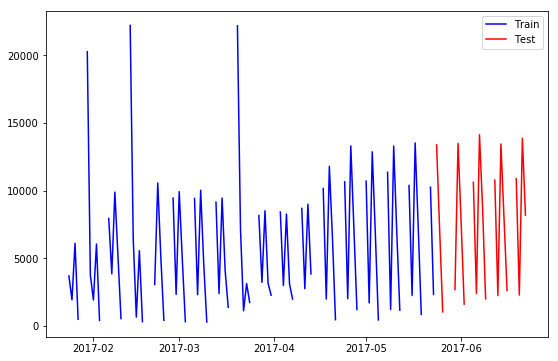

In [187]:
# errors by day
fig, ax = plt.subplots(figsize=(9, 6))
cmask = np.array(x_plt) > pd.to_datetime(train_end).date() # true if test data, false else

test_plt, = ax.plot(np.array(x_plt)[cmask], np.array(y_plt)[cmask], color='red', label='Test')
trn_plt, = ax.plot(np.array(x_plt)[~cmask], np.array(y_plt)[~cmask], color='blue', label='Train')
plt.legend(handles=[trn_plt, test_plt], loc=1)
plt.show()

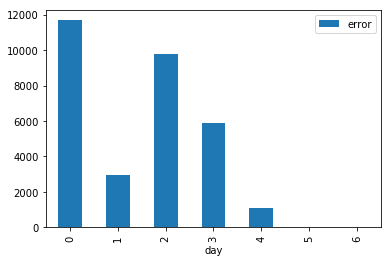

In [196]:
# error by day of week
pd.DataFrame({'day':[a.weekday() for a in x_plt], 'error':y_plt}).groupby('day').mean().plot(kind='bar')